<a href="https://colab.research.google.com/github/haleywis/OPTI556/blob/main/HW4_Wiskoski-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**OPTI-556: Computational Imaging**
**Haley Wiskoski**   
Homework 4: Holography & Fourier Ptychography  
Due: November 2, 2021

(Information in this document is gathered from the Computational Imaging textbook by Dr. David Brady. Implementation is an interpretation of the supplemental codes provided on Github.)

## Libraries

In [60]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import skimage
import os
from matplotlib import animation, rc
from skimage import io
from skimage import transform
from skimage import filters
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.datasets import mnist
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
from google.colab import files
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Model
import cv2
from keras.datasets import mnist
from progressbar import ProgressBar

## 1.) Holography & Phase Retrieval 
For this exercise, we will explore the digital holographic systems described in our class text to simulate holographic recording and recontruction of various objects, namely the mnist dataset of handwritten characters. 

We will simulate both off-axis and in-line holograms, and objects at multiple depths. We will attempt to develop a neural estimator for multiplane objects. For these cases, we will explore performance of algorithms as a function of noise level, sample number, and object complexity. 

### A) Lieth-Upatneiks Holography (off-axis)

Lieth-Upatneiks holographic approach is considered an off-axis process. As opposed to modulating the reference beam, we consider a plane wave reference that propogates at some angle to the signal path. The measurement is represented as such when utilizing a psuedo-random reference signal (uniform intensity across the recording, but random phase).

$g(x) = |{f(x) + r(x)}|^2$  
$g(x) = |f|^2 + |r|^2 + fr*(x) + f*r(x)$

Where the hologram in reconstructed by multiplying the measurement, g(x) by the known distribution of the reference signal, r(x). Propogating g(x)r(x) back to the object plane gives us the estimated signal field, f(x). 



In [61]:
# Loading images
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

In [62]:
# Creating the function for angular spectrum propogation of the 2d image
# this calculates the diffracted field of the 2D image, f, where it propogates
# a distance, d, with certain wavelength relative to pixel pitch

def g(f,d,lam):  # lam is ratio of wavelenght to sampling period(lam << 1)
  zPad=np.int(np.abs(d*lam)) 
  inF=np.zeros(np.add(f.shape,[zPad,zPad])).astype('complex128')
  inF[np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2),np.int(inF.shape[0]/2-f.shape[0]/2):np.int(inF.shape[0]/2+f.shape[0]/2)]=f
  urange=np.linspace(-lam/2,lam/2,inF.shape[0])
  u,v = np.meshgrid(urange,urange)
  g=np.fft.ifft2(np.fft.fft2(inF)*np.fft.fftshift(np.exp(1j *2* np.pi *(d/lam)*np.sqrt( 1 - u**2 - v**2))))
  return g

#### a) Object Complexity Investigation

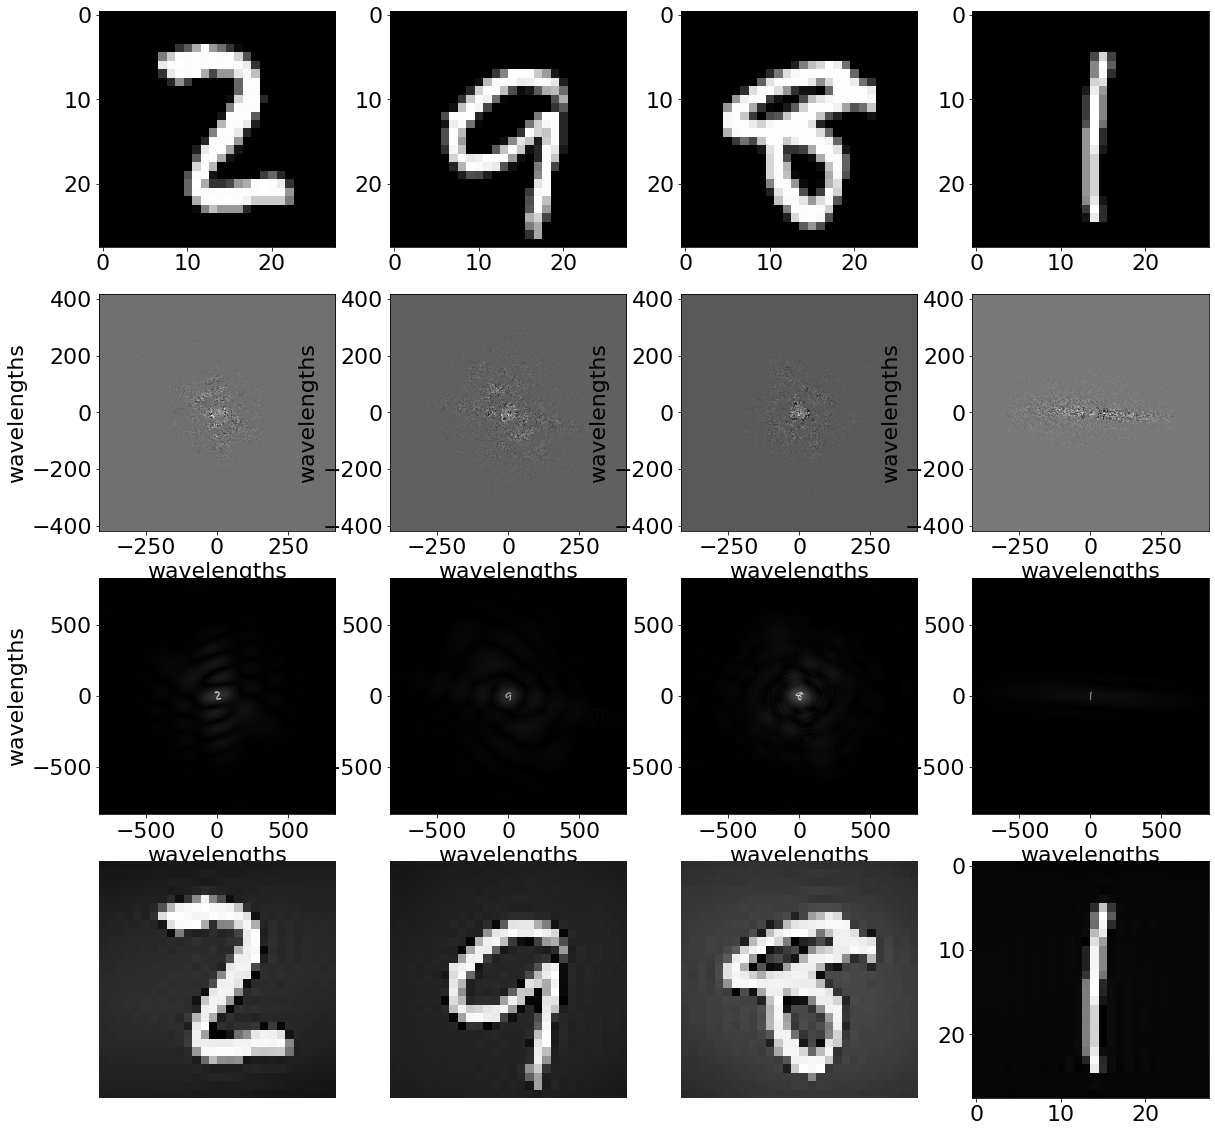

In [63]:
# Implementing the Leith-Upatneiks algorithm with random reference signal

# diffracted field
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})
r = 1
N = 512
theta = np.pi/50
lam = .3         #ratio of wavelength to the sampling period
d = 1000         #in units of wavelegnths
f = np.zeros([N,N])
noise1=10

# calculating the holograms
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
reference=np.exp(np.pi*1j*np.random.randint(2,size=q.shape))
holo=np.abs(q +reference)**2
hS=holo.shape[0]/4

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1048,:,:]
q2=g(f,d,lam)
xrange=d/(lam*2)
xR2=np.linspace(-xrange,xrange,q2.shape[0])
reference2=np.exp(np.pi*1j*np.random.randint(2,size=q2.shape))
holo2=np.abs(q2 +reference2)**2
hS2=holo2.shape[0]/4

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1052,:,:]
q3=g(f,d,lam)
xrange=d/(lam*2)
xR3=np.linspace(-xrange,xrange,q3.shape[0])
reference3=np.exp(np.pi*1j*np.random.randint(2,size=q3.shape))
holo3=np.abs(q3 +reference3)**2
hS3=holo3.shape[0]/4

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1075,:,:]
q4=g(f,d,lam)
xrange=d/(lam*2)
xR4=np.linspace(-xrange,xrange,q4.shape[0])
reference4=np.exp(np.pi*1j*np.random.randint(2,size=q4.shape))
holo4=np.abs(q4 +reference4)**2
hS4=holo4.shape[0]/4

# plotting object images
plt.subplot(4,4,1)
plt.imshow(x_test[1036,:,:],cmap='gray', aspect='equal')
plt.subplot(4,4,2)
plt.imshow(x_test[1048,:,:],cmap='gray', aspect='equal')
plt.subplot(4,4,3)
plt.imshow(x_test[1052,:,:],cmap='gray', aspect='equal')
plt.subplot(4,4,4)
plt.imshow(x_test[1075,:,:],cmap='gray', aspect='equal')

# plotting recorded hologram
plt.subplot(4,4,5)
plt.imshow(holo[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,4,6)
plt.imshow(holo2[np.int(hS2):np.int(3*hS2),np.int(hS2):np.int(3*hS2)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,4,7)
plt.imshow(holo3[np.int(hS3):np.int(3*hS3),np.int(hS3):np.int(3*hS3)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,4,8)
plt.imshow(holo4[np.int(hS4):np.int(3*hS4),np.int(hS4):np.int(3*hS4)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4], cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

# plotting full signal field after g(x)r(x) propogation
plt.subplot(4,4,9)
pip=g(reference*(holo-1),-d,lam)
xrange=d/lam
hS=pip.shape[0]/4
plt.imshow(np.abs(pip)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,4,10)
pip2=g(reference2*(holo2-1),-d,lam)
xrange=d/lam
hS2=pip2.shape[0]/4
plt.imshow(np.abs(pip2)[np.int(hS2):np.int(3*hS2),np.int(hS2):np.int(3*hS2)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,4,11)
pip3=g(reference3*(holo3-1),-d,lam)
xrange=d/lam
hS3=pip3.shape[0]/4
plt.imshow(np.abs(pip3)[np.int(hS3):np.int(3*hS3),np.int(hS3):np.int(3*hS3)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')
plt.subplot(4,4,12)
pip4=g(reference4*(holo4-1),-d,lam)
xrange=d/lam
hS4=pip4.shape[0]/4
plt.imshow(np.abs(pip4)[np.int(hS4):np.int(3*hS4),np.int(hS4):np.int(3*hS4)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.xlabel('wavelengths')
plt.ylabel('wavelengths')

# plotting magnified recontruction
plt.subplot(4,4,13)
plt.imshow(np.abs(pip[542:570,542:570]),cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,14)
plt.imshow(np.abs(pip2[542:570,542:570]),cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,15)
plt.imshow(np.abs(pip3[542:570,542:570]),cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,16)
plt.imshow(np.abs(pip4[542:570,542:570]),cmap='gray', aspect='equal')



#### b) Added Noise Investigation

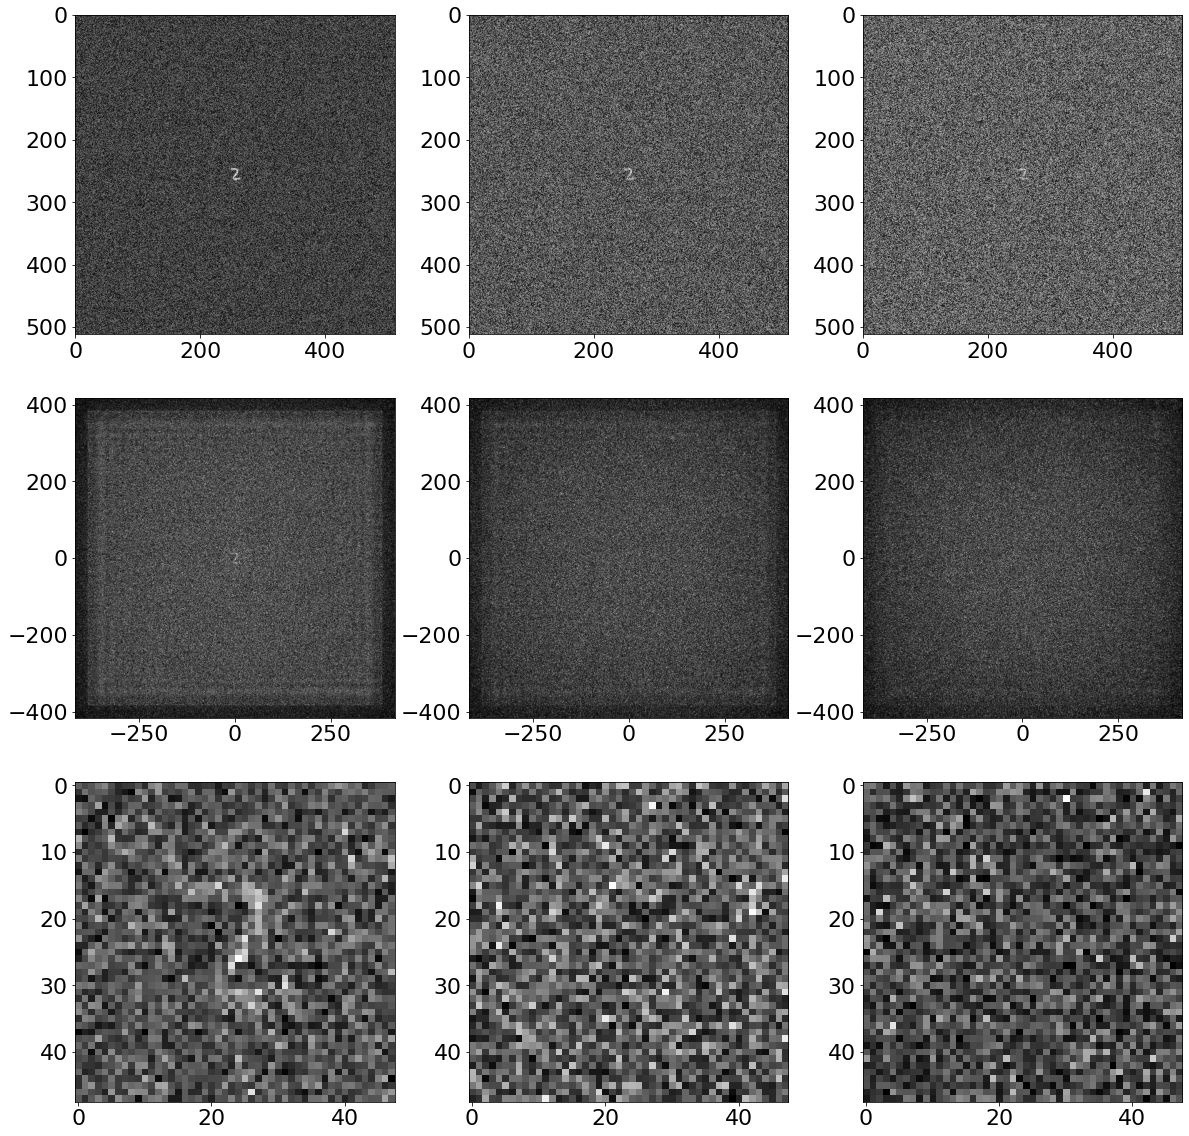

In [65]:
noise3 = 3 
noise2 = 2
noise1 = 1

# calculating the holograms
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
xrange=d/(lam*2)
f_noise1 = f + noise1*np.random.random((512,512))
q_noise1 = g(f_noise1, d, lam)
ref_noise =np.exp(np.pi*1j*np.random.randint(2,size=q_noise1.shape))
holo_noise=np.abs(q_noise1 +ref_noise)**2
hS_noise=holo_noise.shape[0]/4
pip_noise=g(ref_noise*(holo_noise-1),-d,lam)

f_noise2 = f + noise2*np.random.random((512,512))
ref_noise2 =np.exp(np.pi*1j*np.random.randint(2,size=q_noise2.shape))
holo_noise2=np.abs(q_noise2 +ref_noise2)**2
hS_noise2=holo_noise2.shape[0]/4
pip_noise2=g(ref_noise2*(holo_noise2-1),-d,lam)

f_noise3 = f + noise3*np.random.random((512,512))
q_noise3 = g(f_noise3, d, lam)
ref_noise3 =np.exp(np.pi*1j*np.random.randint(2,size=q_noise3.shape))
holo_noise3=np.abs(q_noise3 +ref_noise3)**2
hS_noise3=holo_noise3.shape[0]/4
pip_noise3=g(ref_noise3*(holo_noise3-1),-d,lam)

# plotting results
plt.subplot(3, 3, 1)
plt.imshow(f_noise1, cmap='gray', aspect='equal')
plt.subplot(3, 3, 2)
plt.imshow(f_noise2, cmap='gray', aspect='equal')
plt.subplot(3, 3, 3)
plt.imshow(f_noise3, cmap='gray', aspect='equal')

plt.subplot(3, 3, 4)
hS=pip_noise.shape[0]/4
plt.imshow(np.abs(pip_noise)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.subplot(3, 3, 5)
hS2=pip_noise2.shape[0]/4
plt.imshow(np.abs(pip_noise2)[np.int(hS2):np.int(3*hS2),np.int(hS2):np.int(3*hS2)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.subplot(3, 3, 6)
hS3=pip_noise3.shape[0]/4
plt.imshow(np.abs(pip_noise3)[np.int(hS3):np.int(3*hS3),np.int(hS3):np.int(3*hS3)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')

plt.subplot(3, 3, 7)
plt.imshow(np.abs(pip_noise[532:580,532:580]),cmap='gray', aspect='equal')
plt.subplot(3, 3, 8)
plt.imshow(np.abs(pip_noise2[532:580,532:580]),cmap='gray', aspect='equal')
plt.subplot(3, 3, 9)
plt.imshow(np.abs(pip_noise3[532:580,532:580]),cmap='gray', aspect='equal')


#### c) Sampling Investigation

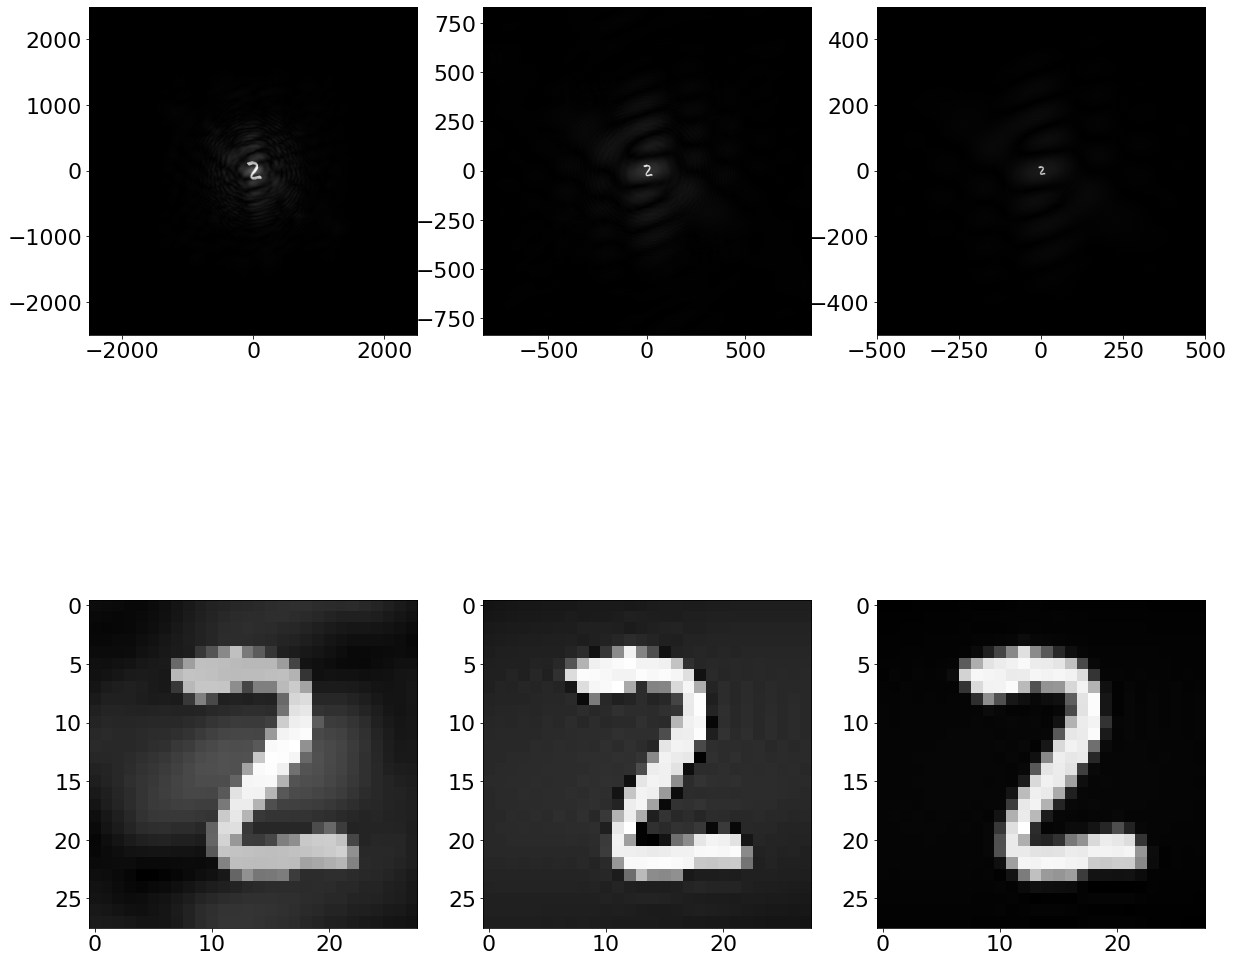

In [66]:
# Implementing the Leith-Upatneiks algorithm with random reference signal

# diffracted field
plt.rcParams['figure.figsize'] = [20, 20]
plt.rcParams.update({'font.size': 22})
N = 512
lam1 = 0.1       #ratio of wavelength to the sampling period
lam2 = 0.3
lam3 = 0.5        
d = 1000         #in units of wavelegnths
f = np.zeros([N,N])

# calculating the holograms
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q1=g(f,d,lam1)
xrange=d/(lam1*2)
reference1=np.exp(np.pi*1j*np.random.randint(2,size=q1.shape))
holo1=np.abs(q1 +reference1)**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q2=g(f,d,lam2)
xrange=d/(lam2*2)
reference2=np.exp(np.pi*1j*np.random.randint(2,size=q2.shape))
holo2=np.abs(q2 +reference2)**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q3=g(f,d,lam3)
xrange=d/(lam3*2)
reference3=np.exp(np.pi*1j*np.random.randint(2,size=q3.shape))
holo3=np.abs(q3 +reference3)**2


# plotting results
plt.subplot(2, 3, 1)
pip1=g(reference1*(holo1-1),-d,lam1)
xrange=d/lam1
hS=pip1.shape[0]/4
plt.imshow(np.abs(pip1)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.subplot(2, 3, 2)
pip2=g(reference2*(holo2-1),-d,lam2)
xrange=d/lam2
hS=pip2.shape[0]/4
plt.imshow(np.abs(pip2)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')
plt.subplot(2, 3, 3)
pip3=g(reference3*(holo3-1),-d,lam3)
xrange=d/lam3
hS=pip3.shape[0]/4
plt.imshow(np.abs(pip3)[np.int(hS):np.int(3*hS),np.int(hS):np.int(3*hS)],extent=[-xrange/4,xrange/4,-xrange/4,xrange/4],cmap='gray', aspect='equal')

plt.subplot(2, 3, 4)
plt.imshow(np.abs(pip1[342:370,342:370]),cmap='gray', aspect='equal')
plt.subplot(2, 3, 5)
plt.imshow(np.abs(pip2[542:570,542:570]),cmap='gray', aspect='equal')
plt.subplot(2, 3, 6)
plt.imshow(np.abs(pip3[742:770,742:770]),cmap='gray', aspect='equal')

#### Discussion

We can see that for the case of no added noise in the off-axis holography implementation, the more complex objects have more obvious interferometric stripes and features. For example, the image of the handwritten 8 has more apparent interferometric features as compared to the more simple object, the handwritten 1, which is almost void of these such features. 

When noise is added to the object, the algorithm struggles to produce a decent reconstruction. It was found that in some iterations of this noise investigation, "ghost" object would appear in the reconstructions. As a general note, it was observed that as noise level increases, a less and less discernable object is created as the signal of the object becomes essentially buried by the noise. After this analysis it was realized that the shot noise should be introduced at the hologram where we weould realistically have a detector, although, the case shown above demonstrates the basic idea of how the algorithm handles noise. It should be noted that the behavior and results of the algorithm may change depending on where noise is introduced, and this could be explored in further depth. 

The last situation explored for Lieth-Upatneiks holography was its performance as a function of sampling. Various values of lambda (ratio of wavelength to pixel pitch) were tested and observed. As the ratio of wavelength to pixel pitch increases closer to 1 (finer sampling), we can observe that the quality of object reconstruction improves. While the relative size of the reconstructed object decreases respectively with increased value of lambda, it can be seen in the magnified reconstruction that there is less blur - per say - surrounding the object, and that the edges appear much cleaner and defined. The reconstructed object for a higher lamda value has more uniform signal intensity compared to the reconstruction from the lower lambda value.

### B) Gabor Holography (in-line)  

In the case of Gabor Holography, instead of considering a plane wave propogating at some angle to the object, the reference beam co-propogates with the signal wave. After backpropogation, we observe interference between the reconstructed object and the digital artifacts of the backpropogated cross terms. 

#### a) Object Complexity Investigation  

We assume these input images are single-depth objects. This is an initial, simple example  utilizing an in-line system with the same geometry used for the Lieth-Upatneiks system. This exercise demonstrates how the algorithm performs  with different levels of object complexity. 

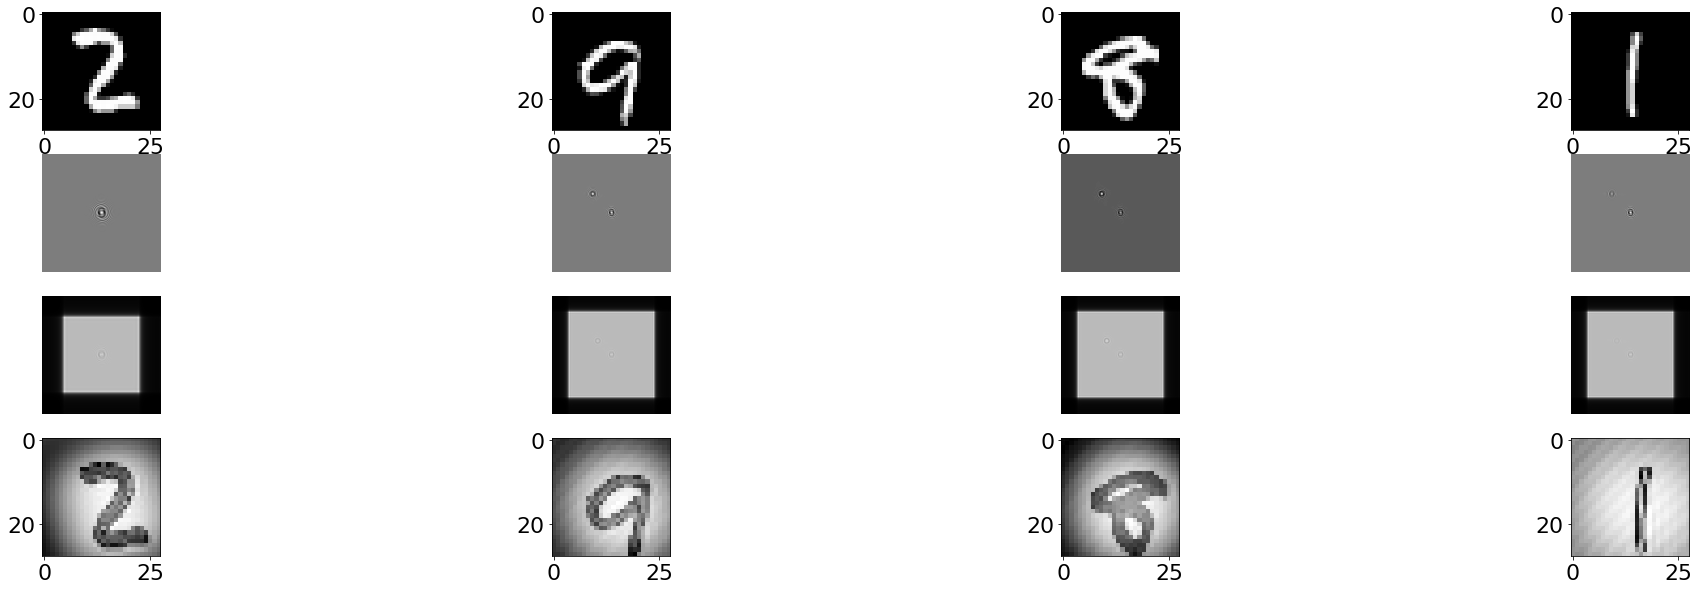

In [67]:
# diffracted field
plt.rcParams['figure.figsize'] = [35, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=256
theta=0
lam=.3 # ratio of wavelength to the sampling period
d=1000 # in units of wavelegnths
f1=np.zeros([N,N])

# insert the mnist image in the center of the field
f1[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q=g(f1,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1048,:,:]
q2=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q2.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo2=np.abs(q2 +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1052,:,:]
q3=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q3.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo3=np.abs(q3 +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1075,:,:]
q4=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q4.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo4=np.abs(q4 +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2



# plotting recorded hologram
plt.subplot(4,4,5)
plt.imshow(holo-r**2,extent=[-xrange,xrange,-xrange,xrange], cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,6)
plt.imshow(holo2-r**2,extent=[-xrange,xrange,-xrange,xrange], cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,7)
plt.imshow(holo3-r**2,extent=[-xrange,xrange,-xrange,xrange], cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,8)
plt.imshow(holo4-r**2,extent=[-xrange,xrange,-xrange,xrange], cmap='gray', aspect='equal')
plt.axis('off')

# plotting full reconstruction 
plt.subplot(4,4,9)
plt.imshow(np.abs(g(holo,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,10)
plt.imshow(np.abs(g(holo2,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,11)
plt.imshow(np.abs(g(holo3,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(4,4,12)
plt.imshow(np.abs(g(holo4,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')

# plotting magnified reconstruction
plt.subplot(4,4,13)
plt.imshow(np.abs(g(holo,-d,lam)[412:440,412:440]),cmap='gray', aspect='equal')
plt.subplot(4,4,14)
plt.imshow(np.abs(g(holo2,-d,lam)[412:440,412:440]),cmap='gray', aspect='equal')
plt.subplot(4,4,15)
plt.imshow(np.abs(g(holo3,-d,lam)[412:440,412:440]),cmap='gray', aspect='equal')
plt.subplot(4,4,16)
plt.imshow(np.abs(g(holo4,-d,lam)[412:440,412:440]),cmap='gray', aspect='equal')


#### b) Sampling Investigation

In this exercise, we will explore the performance of Gabor's in-line holography algorithm as a function of vairous levels of sampling. We will do this my varying the value of "lam", which is the ratio of wavelength to pixel pitch. 

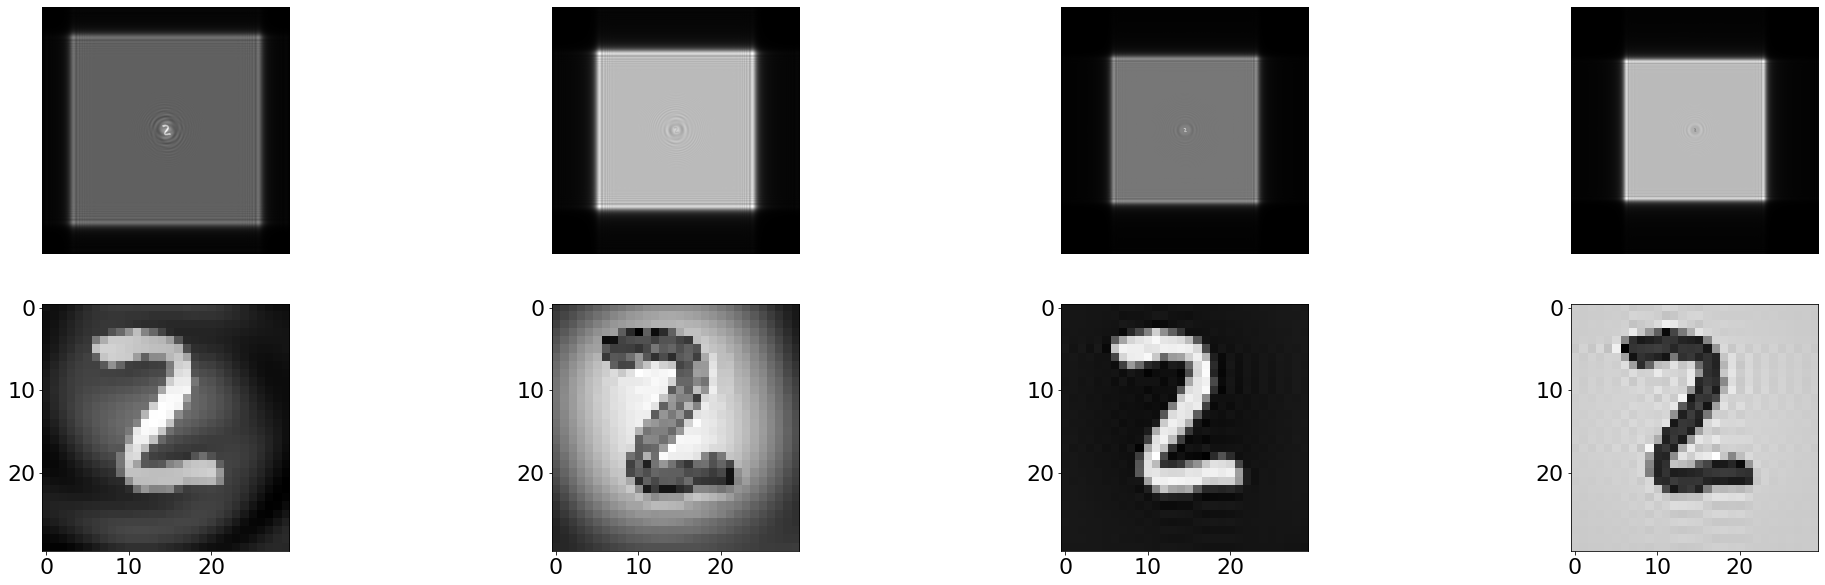

In [195]:
# diffracted field
plt.rcParams['figure.figsize'] = [35, 10]
plt.rcParams.update({'font.size': 22})
r=1
N=256
theta=0
lam = 0.1     # ratio of wavelength to the sampling period
lam2 = 0.3
lam3 = 0.5
lam4 = 0.7
d=1000     # in units of wavelegnths
f = np.zeros([N,N])

# insert the mnist image in the center of the field
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q=g(f,d,lam)
xrange=d/(lam*2)
xR=np.linspace(-xrange,xrange,q.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo=np.abs(q +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q2=g(f,d,lam2)
xrange=d/(lam2*2)
xR=np.linspace(-xrange,xrange,q2.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo3=np.abs(q2 +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q3=g(f,d,lam3)
xrange=d/(lam3*2)
xR=np.linspace(-xrange,xrange,q3.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo3=np.abs(q3 +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2

f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=x_test[1036,:,:]
q4=g(f,d,lam4)
xrange=d/(lam4*2)
xR=np.linspace(-xrange,xrange,q4.shape[0])
xx, yy= np.meshgrid(xR,xR)
holo4=np.abs(q4 +r*np.exp(2*np.pi*1j*xx*np.sin(theta)))**2


# plotting full reconstruction 
plt.subplot(2,4,1)
plt.imshow(np.abs(g(holo,-d,lam)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,4,2)
plt.imshow(np.abs(g(holo2,-d,lam2)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,4,3)
plt.imshow(np.abs(g(holo3,-d,lam3)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')
plt.subplot(2,4,4)
plt.imshow(np.abs(g(holo4,-d,lam4)),extent=[-xrange,xrange,-xrange,xrange],cmap='gray', aspect='equal')
plt.axis('off')

# plotting magnified reconstruction
plt.subplot(2,4,5)
plt.imshow(np.abs(g(holo,-d,lam)[215:245,215:245]),cmap='gray', aspect='equal')
plt.subplot(2,4,6)
plt.imshow(np.abs(g(holo2,-d,lam2)[415:445,415:445]),cmap='gray', aspect='equal')
plt.subplot(2,4,7)
plt.imshow(np.abs(g(holo3,-d,lam3)[615:645,615:645]),cmap='gray', aspect='equal')
plt.subplot(2,4,8)
plt.imshow(np.abs(g(holo4,-d,lam4)[815:845,815:845]),cmap='gray', aspect='equal')

#### c) Multi-depth Object Investigation

We will now address the meaning of phase in the object. We will introduce surface variation / depth to the object by adding random phase. This will present itself in the reconstruction images as "speckle". 



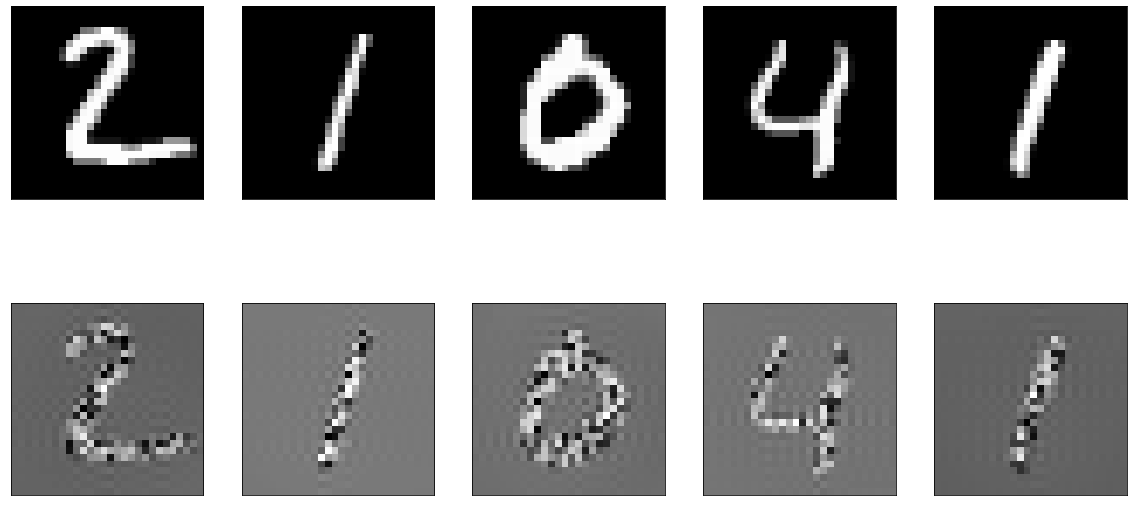

In [114]:
# noise level = 1
plt.figure(figsize=(20, 10))
r=1
N=150
lam=.3 # ratio of wavelength to the sampling period
d=600 # in units of wavelegnths
f=np.zeros([N,N]).astype('complex128')
# insert the mnist image in the center of the field
n = 5

for i in range(1, n + 1):
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(2, n, n+i)
    f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[i,:,:]
    q=g(f,d,lam)
    holo=np.abs(q +r)**2
    plt.imshow(np.abs(g(holo,-d,lam)[241:269,241:269]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

(-0.5, 27.5, 27.5, -0.5)

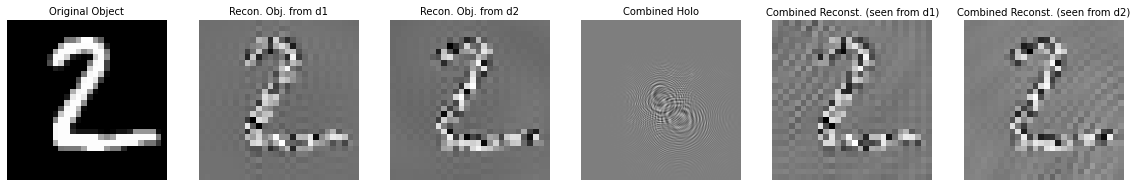

In [154]:
# Creating images of object at multiple depths 

plt.figure(figsize=(20, 10))
r=1
N=150
lam=.3       # ratio of wavelength to the sampling period
d1=600       # in units of wavelegnths
d2=400
f=np.zeros([N,N]).astype('complex128')
holo_comb = np.zeros([N,N])
n = 4
i=1

plt.subplot(1, 6, 1)
plt.imshow(x_test[1].reshape(28, 28)) # object
plt.title('Original Object', fontsize=10)
plt.gray()
plt.axis('off')
plt.subplot(1, 6, 2)
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[1,:,:]
q1=g(f,d1,lam)
holo1=np.abs(q1 +r)**2
plt.imshow(np.abs(g(holo1,-d1,lam)[241:269,241:269])) #obj dist1
plt.title('Recon. Obj. from d1', fontsize=10)
plt.gray()
plt.axis('off')
plt.subplot(1, 6, 3)
f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[i,:,:]
q2 = g(f,d2,lam)
holo2 = np.abs(q2+r)**2
plt.imshow(np.abs(g(holo2,-d2,lam)[181:209,181:209])) #obj dist2
plt.title('Recon. Obj. from d2', fontsize=10)
plt.gray()
plt.axis('off')
plt.subplot(1, 6, 4)
holo_comb = (holo1[0:w2, 0:h2] + holo2) / 2
plt.imshow(holo_comb / np.mean(holo_comb)) #combined hologram
plt.title('Combined Holo', fontsize=10)
plt.gray()
plt.axis('off')
plt.subplot(1, 6, 5)
plt.imshow(np.abs(g(holo_comb,-d1,lam)[241:269,241:269]))
plt.title('Combined Reconst. (seen from d1)', fontsize=10)
plt.gray()
plt.axis('off')
plt.subplot(1, 6, 6)
plt.imshow(np.abs(g(holo_comb,-d2,lam)[181:209,181:209]))
plt.title('Combined Reconst. (seen from d2)', fontsize=10)
plt.gray()
plt.axis('off')


#### d) Neural Estimator for Multiplane Objects

In this last exercise for the holography & phase retrieval portion of the assignment, we will implement a neural estimator to apply to the multiplane/multidepth images from above. 

This neural estimator used to remove the background and speckle of the random phase gabor reconstructions. 


In [ ]:
# loading dataset of handwritten characters 
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.astype("float32")/255.0
x_test=x_test.astype("float32")/255.0

g_test=np.zeros((len(x_test),28,28,2))
g_train=np.zeros((len(x_train),28,28,2))

In [ ]:
# generation of test & training inputs

r=1
N=150
lam=.3       # ratio of wavelength to the sampling period
d=600        # in units of wavelegnths
f = np.zeros([N,N]).astype('complex128')
pbar1 = ProgressBar()
pbar2 = ProgressBar()

# test inputs
for pop in pbar1(range(np.shape(x_test)[0])):
  f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_test[pop,:,:]
  q=g(f,d,lam)
  holo=np.abs(q +r)**2
  iq=g(holo,-d,lam)[241:269,241:269]
  iq=iq/np.max(np.abs(iq))
  g_test[pop,:,:,0]=(1+np.real(iq))/2
  g_test[pop,:,:,1]=(1+np.imag(iq))/2

# training inputs
for pop in pbar2(range(np.shape(x_train)[0])):
  f[np.int(N/2-14):np.int(N/2+14),np.int(N/2-14):np.int(N/2+14)]=np.exp(2*np.pi*1j*np.random.random((28,28)))*x_train[pop,:,:]
  q=g(f,d,lam)
  holo=np.abs(q +r)**2
  iq=g(holo,-d,lam)[241:269,241:269]
  iq=iq/np.max(np.abs(iq))
  g_train[pop,:,:,0]=(1+np.real(iq))/2
  g_train[pop,:,:,1]=(1+np.imag(iq))/2

x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

np.savez('trainingArrays',g_test,g_train)
files.download('trainingArrays.npz')

In [ ]:
# Creating the estimation model
inputs=keras.Input(shape=(28, 28, 2))

# Encoder
x = layers.Conv2D(32, (5, 5), strides=1, activation="relu", padding="same")(inputs)
x = layers.Conv2D(64, (4, 4), strides=2, activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(64, (3, 3), strides=1, activation="relu", padding="same")(x)


# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(16, (3, 3), strides=1, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(8, (3, 3), activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(1, (3, 3), activation="linear", padding="same")(x)

gaborEstimator = keras.Model(inputs, x)
gaborEstimator.compile(optimizer='adam', loss='mean_squared_error')
gaborEstimator.summary()

In [ ]:
# Training the estimator
gaborEstimator.fit(
    x=g_train,
    y=x_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(g_test, x_test),
)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

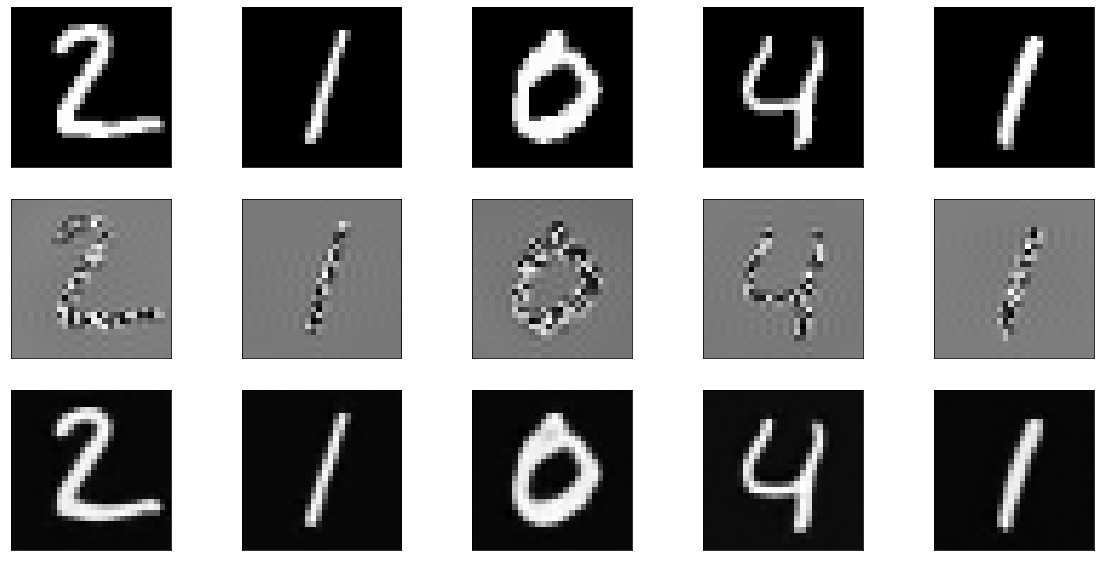

In [155]:
# Showing our results from the neural estimator
n = 5
plt.figure(figsize=(20, 10))
for i in range(1, n + 1):
    ax = plt.subplot(3, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, n+i)
    plt.imshow(g_test[i,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax = plt.subplot(3, n, 2*n+i)
    plt.imshow(gaborEstimator.predict(g_test[i:i+1,:,:,:])[0,:,:,0])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('neuralGaborDespeckle.pdf')
files.download('neuralGaborDespeckle.pdf')

#### Discussion




### 2.) Phase Retrieval Image Reconstruction & Fourier Ptychography 

In this exercise we will be implementing a few reference-free phase retrieval reconstruction algorithms and conmparing their results for various objects. We will try to compare the performance of these algorithms for various object complexities, noise levels, and number of samples. 

Finally, we will attempt to implement Fourier Ptychography on some of the reconstructions produced. 

#### a) Fienup Hybrid Input-Output Phase Retrieval  


In [ ]:
# number of iterations and value of beta
iterations=200
beta=0.3

# input image field
im1=x_test[1036,:,:]
im2=x_test[1052,:,:]
im3=x_test[1075,:,:]

# test image 1
f=np.pad(im1,np.int((256-im1.shape[0])/2))
hatf=np.abs(np.fft.fft2(f))
hatPhi=2*np.pi*np.random.random(hatf.shape)
fest=np.zeros(np.shape(f))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf*np.exp(1j*hatPhi)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest=np.reshape(pf,np.shape(f))
  hatPhi=np.angle(np.fft.fft2(fest))

# test image 2
f2 =np.pad(im2,np.int((256-im2.shape[0])/2)) 
hatf2=np.abs(np.fft.fft2(f2))
hatPhi2=2*np.pi*np.random.random(hatf2.shape)
fest2=np.zeros(np.shape(f2))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf2*np.exp(1j*hatPhi2)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest2)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest2=np.reshape(pf,np.shape(f2))
  hatPhi2=np.angle(np.fft.fft2(fest2))

# test image 3
f3 =np.pad(im3,np.int((256-im3.shape[0])/2)) 
hatf3=np.abs(np.fft.fft2(f3))
hatPhi3=2*np.pi*np.random.random(hatf3.shape)
fest3=np.zeros(np.shape(f3))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf3*np.exp(1j*hatPhi3)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest3)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest3=np.reshape(pf,np.shape(f3))
  hatPhi3=np.angle(np.fft.fft2(fest3))

# plotting results
plt.subplot(3, 3, 1)
plt.imshow(f, cmap='gray', aspect='equal')
plt.subplot(3, 3, 2)
plt.imshow(f2, cmap='gray', aspect='equal')
plt.subplot(3, 3, 3)
plt.imshow(f3, cmap='gray', aspect='equal')
plt.subplot(3, 3, 4)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf))), cmap='gray', aspect='equal')
plt.subplot(3, 3, 5)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf2))), cmap='gray', aspect='equal')
plt.subplot(3, 3, 6)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf3))), cmap='gray', aspect='equal')
plt.subplot(3, 3, 7)
plt.imshow(fest, cmap='gray', aspect='equal')
plt.subplot(3, 3, 8)
plt.imshow(fest2, cmap='gray', aspect='equal')
plt.subplot(3, 3, 9)
plt.imshow(fest3, cmap='gray', aspect='equal')


In [ ]:
# investigating how the algorithm handles noise
n1 = 1
n2 = 5
n3 = 10

# noise level 1
f=np.pad(im1,np.int((256-im1.shape[0])/2))
f_noise = f + np.random.random((256,256))
hatf=np.abs(np.fft.fft2(f_noise))
hatPhi=2*np.pi*np.random.random(hatf.shape)
fest=np.zeros(np.shape(f_noise))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf*np.exp(1j*hatPhi)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest=np.reshape(pf,np.shape(f_noise))
  hatPhi=np.angle(np.fft.fft2(fest))

# noise level 2
f2_noise = f + 2*np.random.random((256,256))
hatf2=np.abs(np.fft.fft2(f2_noise))
hatPhi2=2*np.pi*np.random.random(hatf2.shape)
fest2=np.zeros(np.shape(f2_noise))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf2*np.exp(1j*hatPhi2)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest2)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest2=np.reshape(pf,np.shape(f2_noise))
  hatPhi2=np.angle(np.fft.fft2(fest2))

# noise level 3
f3_noise = f + 3*np.random.random((256,256))
hatf3=np.abs(np.fft.fft2(f3_noise))
hatPhi3=2*np.pi*np.random.random(hatf3.shape)
fest3=np.zeros(np.shape(f3_noise))
for pop in range(iterations):
  tf=np.real(np.fft.ifft2(hatf3*np.exp(1j*hatPhi3)))
  tfL=np.ndarray.flatten(tf)
  pf=np.ndarray.flatten(fest3)
  for pip in range(len(tfL)):
    if tfL[pip]<0:
      pf[pip]=pf[pip]-beta*tfL[pip]
    else:
      pf[pip]=tfL[pip]
  fest3=np.reshape(pf,np.shape(f3_noise))
  hatPhi3=np.angle(np.fft.fft2(fest3))

# plotting results
plt.subplot(3, 3, 1)
plt.imshow(f_noise, cmap='gray', aspect='equal')
plt.subplot(3, 3, 2)
plt.imshow(f2_noise, cmap='gray', aspect='equal')
plt.subplot(3, 3, 3)
plt.imshow(f3_noise, cmap='gray', aspect='equal')
plt.subplot(3, 3, 4)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf))), cmap='gray', aspect='equal')
plt.subplot(3, 3, 5)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf2))), cmap='gray', aspect='equal')
plt.subplot(3, 3, 6)
plt.imshow(np.real(np.fft.fftshift(np.fft.ifft2(hatf3))), cmap='gray', aspect='equal')
plt.subplot(3, 3, 7)
plt.imshow(fest, cmap='gray', aspect='equal')
plt.subplot(3, 3, 8)
plt.imshow(fest2, cmap='gray', aspect='equal')
plt.subplot(3, 3, 9)
plt.imshow(fest3, cmap='gray', aspect='equal')


#### b) Gerchberg-Saxton Phase Retrieval 

The following is an investigation of the Gerchberg-Saxton phase retrieval algorithm. Code implemented below was gathered from the user "wxwang0104" on Github at the following link: 
https://github.com/wxwang0104/Phase_retrieval_single_constraint/blob/master/phase_retrieval_GS.py

In [ ]:
# defining the Gerchberg-Saxton function (gathered from above source)
def Ger_Sax_algo(img, max_iter):
    h, w = img.shape
    pm_s = np.random.rand(h, w)
    pm_f = np.ones((h, w))
    am_s = np.sqrt(img)
    am_f = np.ones((h, w))

    signal_s = am_s*np.exp(pm_s * 1j)

    for iter in range(max_iter):
        signal_f = np.fft.fft2(signal_s)
        pm_f = np.angle(signal_f)
        signal_f = am_f*np.exp(pm_f * 1j)
        signal_s = np.fft.ifft2(signal_f)
        pm_s = np.angle(signal_s)
        signal_s = am_s*np.exp(pm_s * 1j)

    pm =pm_f
    return pm

In [ ]:
f=np.pad(im1,np.int((256-im1.shape[0])/2))
f2 =np.pad(im2,np.int((256-im2.shape[0])/2)) 
f3 =np.pad(im3,np.int((256-im3.shape[0])/2)) 


# reconstruction of various images
phasemask1 = Ger_Sax_algo(f, 50)
phasemask2 = Ger_Sax_algo(f2, 50)
phasemask3 = Ger_Sax_algo(f3, 50)

recovered1 = np.fft.ifft2(np.exp(phasemask1*1j))
recovered2 = np.fft.ifft2(np.exp(phasemask2*1j))
recovered3 = np.fft.ifft2(np.exp(phasemask3*1j))

plt.subplot(3,3,1)
plt.imshow(f, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,2)
plt.imshow(f2, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,3)
plt.imshow(f3, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,4)
plt.imshow(phasemask1, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,5)
plt.imshow(phasemask2, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,6)
plt.imshow(phasemask3, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,7)
plt.imshow(np.absolute(recovered1)**2, cmap = "gray", aspect = "equal")
plt.subplot(3,3,8)
plt.imshow(np.absolute(recovered2)**2, cmap = "gray", aspect = "equal")
plt.subplot(3,3,9)
plt.imshow(np.absolute(recovered3)**2, cmap = "gray", aspect = "equal")

In [ ]:
# adding noise to the objects
f_noise = f + np.random.random((256,256))
f2_noise = f + 2*np.random.random((256,256))
f3_noise = f + 5*np.random.random((256,256))

phasemask1 = Ger_Sax_algo(f_noise, 1000)
phasemask2 = Ger_Sax_algo(f2_noise, 1000)
phasemask3 = Ger_Sax_algo(f3_noise, 1000)

recovered1 = np.fft.ifft2(np.exp(phasemask1*1j))
recovered2 = np.fft.ifft2(np.exp(phasemask2*1j))
recovered3 = np.fft.ifft2(np.exp(phasemask3*1j))

plt.subplot(3,3,1)
plt.imshow(f_noise, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,2)
plt.imshow(f2_noise, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,3)
plt.imshow(f3_noise, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,4)
plt.imshow(phasemask1, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,5)
plt.imshow(phasemask2, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,6)
plt.imshow(phasemask3, cmap = 'gray', aspect = 'equal')
plt.subplot(3,3,7)
plt.imshow(np.absolute(recovered1)**2, cmap = "gray", aspect = "equal")
plt.subplot(3,3,8)
plt.imshow(np.absolute(recovered2)**2, cmap = "gray", aspect = "equal")
plt.subplot(3,3,9)
plt.imshow(np.absolute(recovered3)**2, cmap = "gray", aspect = "equal")

#### Discussion  

For the first phase retrieval algorithm implementation of Fienup's HIO, there are a few interesting things to point out. In testing the case of object complexity, we can see that the algorithm struggled to produce a reasonable image of the more complex character, 8. The reconstruction of this character is quite blurry, and almost unrecognizable as an 8. The algorithm performed well for the simple character, 1, as the reconstruction of the image resembles the original. This is expected due to the low complexity of the object's FT. The reconstruction of the handwritten 2, although resembling its original, appears to possess a sort of wraparound artifact as the right-half of the character exists on the lefthand side of the reconstructed image. This is most likely a result of not enough padding on the image, and is an expected results when utilizing fourier transforms. This artifact only occured a few times out of the several times the algorithm was run. The location of the reconstructed object changes each time, as we know from the textbook discussion (due to "insensitivity of the measurement to phase modulation linear in x"). 

When noise was introduced, this algorithm was unable to reconstruct the original image. 

One other investigation done here was the algorithm's performance as a function of number of iterations. The initial test was done with 200 iterations; doubling and even tripling this value did not produce any greater reconstruction of the more complex character, 8. This was an interesting find, as we would assume that greater iterations would lead to a better approximation of the object. There was also no observable difference in the reproductions when the number of iterations was quartered to a total of 50. I had also explored the performance of this algorithm with various relaxation constants. For beta = 0.3, the "2" and "8" reconstructions remained visibly the same, but the reconstruction of the "1" changed drastically - the object was repeated in numerous locations of the reconstructed image as opposed to one single reconstruction of the object. A higher reconstruction value than the initial beta = 0.8 produced no observable difference, but anything less than 0.8 resulted in "ghost" reconstructions of the "1" image. 

-------------------------------------------------
The Gerchberg-Saxton phase retrieval algorthim was the second method explored. This algorithm proved to perform better than Fienup's HIO and ran significantly faster. In the first implementation, it can be observed that the more complex object "8" was reconstructed very well. Another thing to point out is that the reconstructed object remained centered in the final reconstructed image. The wraparound artifact did not occur using this algorithm.

The number of iterations necessary for a reasonable reconstruction was explored. The initial number of iterations used was 1000, but after a few trials, it was determined that an equally reasonable reconstruction is able to be obtained using only 50 iterations or less. Even at this value, the algorithm still performed better than the prior. 

A second investigation was performed on this algorithm exploring the performance as a function of noise level. As opposed to Fienup's algorithm, the Gerchberg-Saxton implementation handled the noise levels well, and were able to still produce acceptable reconstructions of the objects within reason (noise level = 5 was the maximum before the reconstruction was borderline undetectable).